In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Readme
Change dataset, crop_id, obj_id only

# 1. Crop images

In [2]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model)

In [3]:
def move_to_device(segmentor_model, device="cuda"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

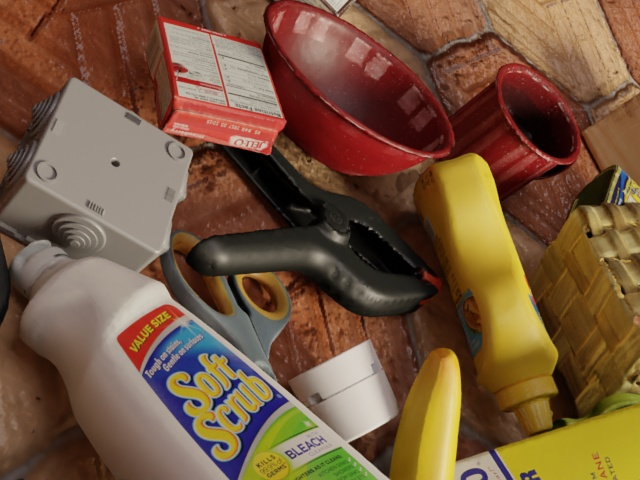

In [4]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "ycbv"
rgb_path = f"datasets/bop23_challenge/datasets/{dataset}/train_pbr/000001/rgb/000001.jpg"
rgb = Image.open(rgb_path).convert("RGB")
detections = custom_sam_model.generate_masks(np.array(rgb))
rgb

In [5]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

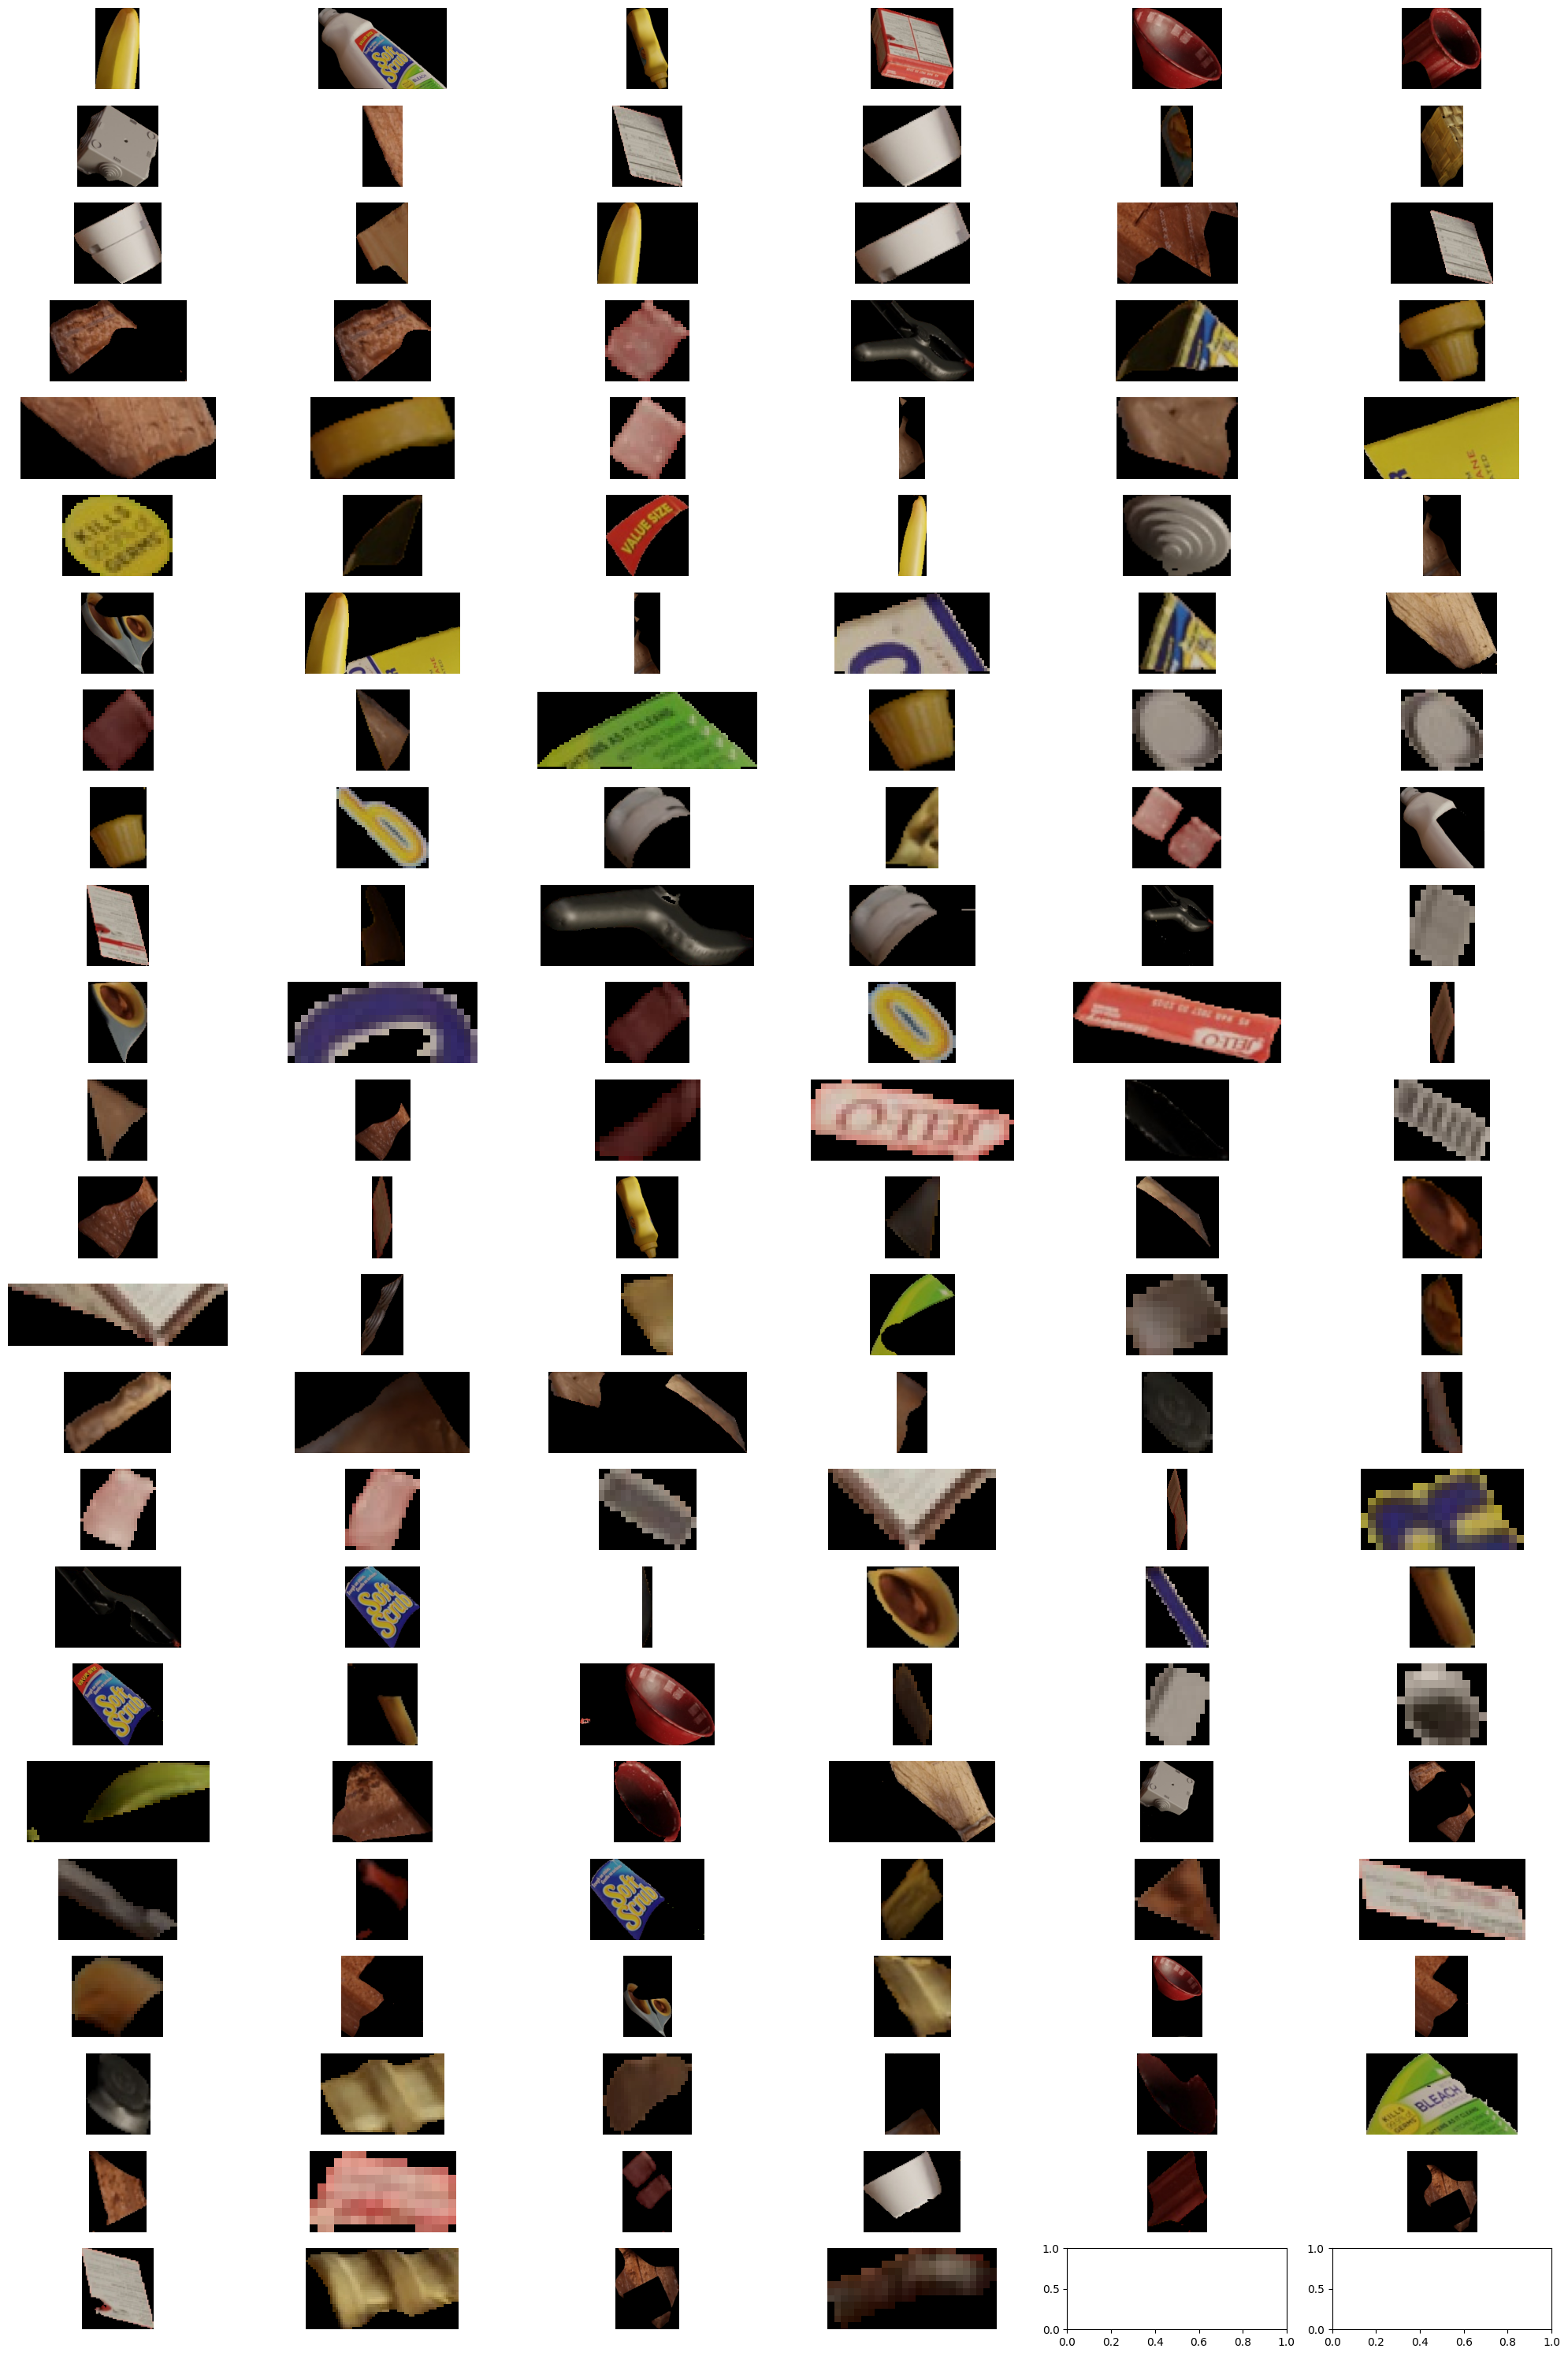

In [6]:
# Visualize proposals
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define the number of rows and columns in the grid
rows = ceil(len(masked_images) / 6)
cols = 6
# Plot the masked_images array in a grid
plot_images(masked_images, rows, cols) 

In [7]:
import os

# Choose crop 4 it is in object id 12
crop_idx = 3
obj_id = 2
crop1 = {
    "crop" : masked_images[crop_idx], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : detections["masks"][crop_idx],
    "boxes" : detections["boxes"][crop_idx]
}
# save image
if not os.path.exists(f"foundpose_analysis/{dataset}"):
    os.makedirs(f"foundpose_analysis/{dataset}")
crop1["crop"].save(f"foundpose_analysis/{dataset}/crop1.png")

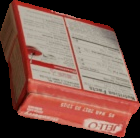

In [8]:
crop1["crop"]

# 2. Templates

## 2.1 Create templates of object

In [9]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

/tmp/ipykernel_2608365/531409554.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs")


In [37]:
import os
import glob

default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = f"datasets/bop23_challenge/datasets/{dataset}"
ref_dataloader_config.template_dir = " "

level_template = 1 # Level 0 :42 templates, level 1, 162 templates
ref_dataloader_config.level_templates = level_template 
ref_dataloader_config.split = "test" # train_pbr

ply_files = glob.glob(f"datasets/bop23_challenge/datasets/{dataset}/models/models/*.ply")
obj_ids = sorted([int(os.path.basename(obj_id)[8:10]) for obj_id in ply_files])
ref_dataloader_config.obj_ids = obj_ids

out_folder = f"foundpose_analysis/{dataset}/templates"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
ref_dataloader_config.out_dir = out_folder
ref_dataloader_config.templates_output_folder = f"{out_folder}/level_template_{level_template}"

In [38]:
import os
os.environ['HYDRA_FULL_ERROR'] = '1'

In [58]:
# # Error : must delete all metadata.csv 
# # If using test it can happen that the object id doesnt appear in the test folder- so can get empty list - just use try except la ok
# from hydra.utils import instantiate
# ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
# ref_dataset.load_processed_metaData(reset_metaData=True)

Loading metaData: 100%|██████████| 10/10 [00:00<00:00, 194.84it/s]
Finding nearest rendering close to template poses: 100%|██████████| 21/21 [00:00<00:00, 231.87it/s]


In [56]:
# from torchvision.utils import save_image
# import pandas as pd

# templates = pd.read_csv(f"{out_folder}/{ref_dataloader_config.split}_processed_metaData.csv")

# # Save templates as images
# for ob_id in range(len(obj_ids)): 
#     obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}') # The transformed templates - check line 244, 245 in bop_pbr.py
#     original_obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}_original')
    
#     if not os.path.exists(obj_id_path):
#         os.makedirs(obj_id_path)
#     if not os.path.exists(original_obj_id_path):
#         os.makedirs(original_obj_id_path)

#     try:  
#         for i, img in enumerate(ref_dataset[ob_id]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
#         for i, img in enumerate(ref_dataset[ob_id]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))
#     except Exception as e:
#         print(f"An error occurred: {e}")

An error occurred: single positional indexer is out-of-bounds
An error occurred: single positional indexer is out-of-bounds


## 2.2. Templates features extraction

In [136]:
import glob
import os

obj_id_2 = 3
data_type = "train_pbr" # test

# Load original templates when before putting through dinov2 we also apply transfomation.
template_path_1 = "datasets/bop23_challenge/datasets/templates_pyrender/ycbv/obj_000002" # f"{out_folder}/{data_type}_images_templates/obj_{obj_id:06d}_original" 
template_path_2 = f"{out_folder}/{data_type}_images_templates/obj_{obj_id_2:06d}_original" 
template_files_1 = sorted(glob.glob(os.path.join(template_path_1, "*.png")), key=os.path.getmtime)
template_files_2 = sorted(glob.glob(os.path.join(template_path_2, "*.png")), key=os.path.getmtime)
template_files = template_files_1 
num_templates = len(template_files)
num_templates

642

In [137]:
from PIL import Image
import numpy as np
# [50:450, 150:500, :3] only for pyrender template not for BlenderProc templates
templates = [np.array(Image.open(template_file).convert("RGB"))[50:450, 150:500, :3] 
                for template_file in template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


In [148]:
from src.model.foundpose import resize_and_pad_image
import torchvision.transforms as T
def cnos_templates_feature_extraction(templates, dino_model, num_templates, device):
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )

    normalized_templates = [rgb_normalize(template/255.0).float() for template in templates]
    # normalized_crop_rgb = torch.tensor(crop_rgb, dtype=torch.float32).permute(2,0,1)
    print("normalized_templates shape", normalized_templates[0].shape)

    scaled_padded_templates = [resize_and_pad_image(normalized_template, target_max=224)
                            for normalized_template in normalized_templates] # Unsqueeze to make it as a stack of proposals - here we use only 1 proposals
    print("scaled_padded_templates.shape", len(scaled_padded_templates), scaled_padded_templates[0].shape) 

    
    plt.imshow(templates[0]) #, cmap=plt.cm.gray)
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

    batch_size = 16
    layers_list = list(range(24))
    template_batches = [scaled_padded_templates[i:i+batch_size] for i in range(0, len(scaled_padded_templates), batch_size)]
    patch_features= list()

    for batch in template_batches:
        batch = torch.stack(batch)
        size = batch.shape[0]
        torch.cuda.empty_cache()
        with torch.no_grad(): 
            batch_feature = dino_model.module.get_intermediate_layers(
                batch.to(device), n=layers_list, return_class_token=True
                )[23][1].reshape(size,-1,1024).cpu()
        patch_features.append(batch_feature.to('cpu'))
        del batch_feature
    patch_features = torch.cat(patch_features)
    del dino_model

    return patch_features.squeeze().to("cuda:0")

normalized_templates shape torch.Size([3, 400, 350])
scaled_padded_templates.shape 642 torch.Size([3, 224, 224])


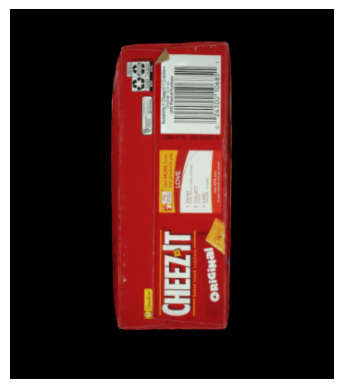

In [149]:
from src.model.foundpose import (
    crop_feature_extraction, 
    kmeans, 
    calculate_templates_labels, 
    calculate_templates_vector,
    calculate_crop_vector,
    calculate_similarity,
    templates_feature_extraction
)


ref_features = cnos_templates_feature_extraction(
    templates = templates, num_templates = num_templates, dino_model = dinov2_vitl14, device = device
    )

In [150]:
ref_features.shape

torch.Size([642, 1024])

# 3. Crop features extraction

In [151]:
# Load image crop 
crop_rgb = np.array(Image.open(f"foundpose_analysis/{dataset}/crop1.png").convert("RGB")) # (124, 157, 3)

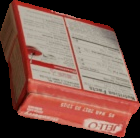

In [152]:
Image.open(f"foundpose_analysis/{dataset}/crop1.png")

In [153]:
def cnos_crop_feature_extraction(crop_rgb, dino_model, device):
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )

    normalized_crop_rgb = rgb_normalize(crop_rgb/255.0).float()
    # normalized_crop_rgb = torch.tensor(crop_rgb, dtype=torch.float32).permute(2,0,1)

    scaled_padded_crop_rgb = resize_and_pad_image(normalized_crop_rgb, target_max=224).unsqueeze(0) # Unsqueeze to make it as a stack of proposals - here we use only 1 proposals
    print("scaled_padded_crop_rgb.shape", scaled_padded_crop_rgb.shape)


    # Extract features from 18th layer of Dinov2 
    layers_list = list(range(24))
    torch.cuda.empty_cache()
    with torch.no_grad(): 
        feature_patches= dino_model.module.get_intermediate_layers(
            scaled_padded_crop_rgb.to(device), n=layers_list, return_class_token=True)[23][1].reshape(-1,1024)
    del dino_model

    return feature_patches

In [154]:
crop_features = cnos_crop_feature_extraction(crop_rgb = crop_rgb, dino_model = dinov2_vitl14, device = device)
crop_features

scaled_padded_crop_rgb.shape torch.Size([1, 3, 224, 224])


tensor([[ 0.2621, -0.6298,  0.5880,  ..., -0.0363,  0.4745, -0.7977]],
       device='cuda:0')

# 4. Retrieve top similar pose

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from src.model.loss import PairwiseSimilarity, Similarity
from torchvision.io import read_image
metric = Similarity() # cnos  uses PairwiseSimilariy - what is the difference between Similarity and Pairwise Similarity ?

def calculate_similarity(crop_rgb, feature_decriptors, ref_features, metric, synthetic=False):
    # get scores per proposal
    scores = metric(feature_decriptors[:, None, :], ref_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
    score_per_detection, similar_template_indices = torch.topk(scores, k=5, dim=-1) # get top 5 most similar templates
    # get the final confidence score
    score_per_detection = torch.mean(
        score_per_detection, dim=-1
    ) 
    # Check the confidence scores for the similar templates
    similar_scores = scores[:, similar_template_indices[0].to("cpu")]

    similar_templates = []
    for i in range(len(similar_template_indices[0])):
        if synthetic:
            img = read_image(template_files[similar_template_indices[0][i]])            
        # else:
        #     img = read_image(f"cnos_analysis/real_images_templates/icbin/obj_000001_original/{(similar_template_indices[0][i]):06d}.png")        
        similar_templates.append(img)
    # template_images = torch.stack(similar_templates)

    # Display the crop
    plt.imshow(crop_rgb)
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

    print("top 5 confidence scores", similar_scores)
    print("final average confidence score", score_per_detection)

    width = 50
    height = 50
    fig = plt.figure(figsize=(15, 15))
    columns = 3
    rows = 2

    for index in range(len(similar_templates)):
        fig.add_subplot(rows, columns, index + 1)
        img = similar_templates[index].permute(1, 2, 0)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Top Template {index + 1}')

    plt.tight_layout()
    plt.show()

    return

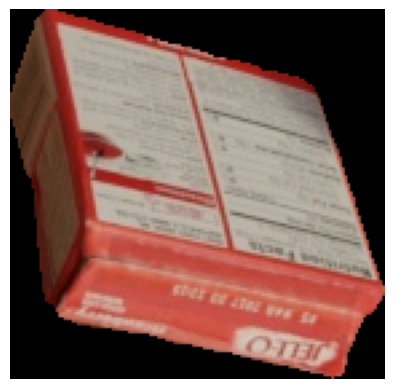

top 5 confidence scores tensor([[0.7067, 0.6979, 0.6960, 0.6928, 0.6918]], device='cuda:0')
final average confidence score tensor([0.6971], device='cuda:0')


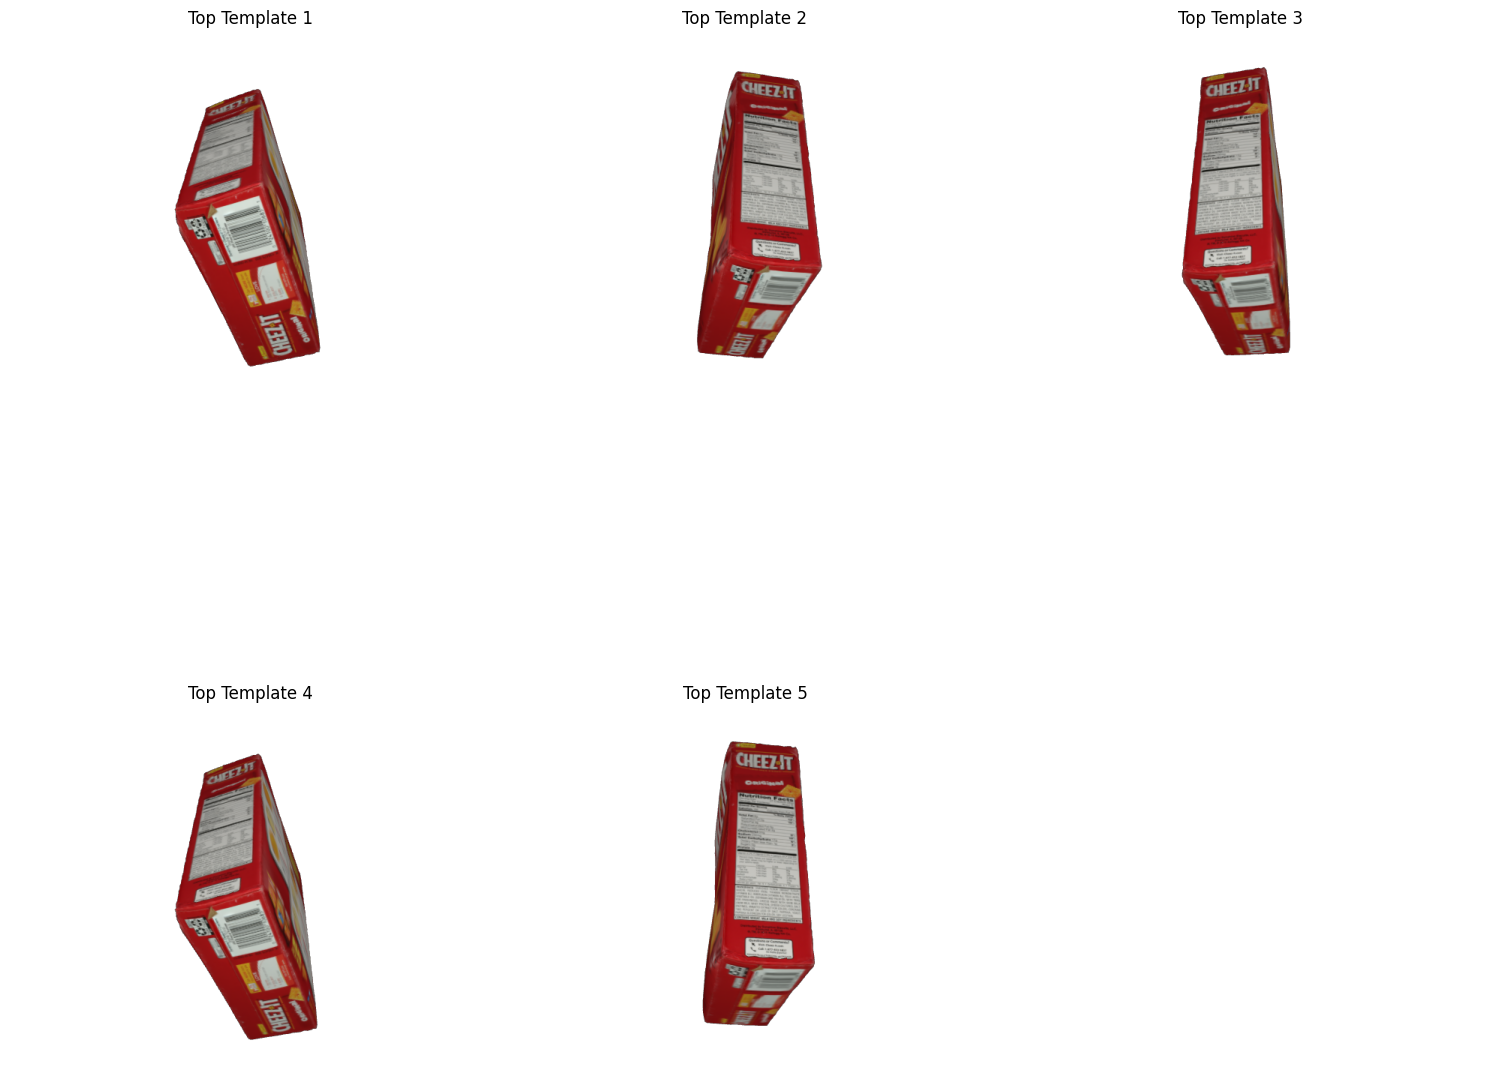

In [156]:
calculate_similarity(crop_rgb, crop_features, ref_features, metric, synthetic=True)